In [6]:
!pip install -q d20 kani[openai] openai

In [7]:
!pip install dotenv

In [8]:
import os
from dotenv import load_dotenv
from kani.engines.openai import OpenAIEngine

load_dotenv()
engine = OpenAIEngine(api_key=os.environ["OPENAI_API_KEY"], model="gpt-4")

In [9]:
SYSTEM_PROMPT = """
You are the Game Master for an RPG adventure game.
When the game starts, call the start_game function and introduce yourself as the Game Master and:
1. Welcome the player to the adventure
2. Describe the game setting and world based on the background information
3. Explain the player's mission and objectives
4. Provide basic instructions on how to play (using commands like move, show_map, etc.)
5. DO NOT mention grids coordinates, but make the move realistic like move to the north, south, east, west, up, down


Make this introduction engaging and immersive to draw the player into the game world.
"""


In [10]:
MAP_INIT_PROMPT = """
Initialize a map at the beginning of the game. The map is a 2D array of size 20x20. The grid's value is initialized using GPT-4o. Each grid's value has 3 attributes: 
(x, y, z). x and y are the coordinates of the grid, z is the height of the grid. x, y has a range of 0-19. z has a range of -2-2. Player can move to the neighbor grids with +1/-1 z value from the current grid. 

Player is initialized at (0, 0, 0). Player can move to a specific grid by using the move function. The move function will return the new player's position.

The destination grid's coordinates are randomly generated. There must exist a path from the player's initial position to the destination grid.

Player finish the game by either reaching a specific grid or the game reaches the max step or the player's health is 0, or specific event happens.
"""

In [11]:
BACKGROUND_INIT_PROMPT_DEFAULT = """
King's Quarters

Any character who listens at the door hears two voices in a heated discussion— a loud, growling voice demanding payment for something, and a silky smooth reply. This chamber has been set up as a crude living space, with thick furs thrown on the floor to serve as carpets, old trophies hanging on the walls, a large bed to the north, and a brazier of coals burning brightly. A round table with several chairs stands to the south near the door. Near the table, on the floor, is an unconscious dwarf who looks badly beaten.

King Grol is a fierce old bugbear with 45 hit points. He rules the Cragmaws through pure intimidation. Age has stooped his shoulders and hunched his back, but he remains surprisingly agile and strong. He is demanding and vindictive, and no Cragmaw dares to cross him.

Grol is attended by Snarl, a wolf with 18 hit points, and a doppelganger disguised as a female drow. The doppelganger, Vyerith, is a messenger from the Black Spider, come to collect Gundren Rockseeker and the map of Wave Echo Cave from King Grol. Grol wants to sell the map instead of surrendering it, and he and the drow are negotiating a price. Vyerith first wants to question Gundren to find out if anyone else knows the location of the mine. Then the doppelganger intends to kill the dwarf and destroy the map.

If the villains have been warned that an attack is imminent, Vyerith hides behind the door to the northeast, leaving it open a crack and hoping to attack an intruder from the rear. Grol holds Gundren hostage, ready to kill the dwarf if the characters don’t back off.

Awarding Experience Points:
Divide 950 XP equally among the characters if the party defeats King Grol, the wolf, and the doppelganger. Award an additional 200 XP to the party if the characters rescue Gundren Rockseeker and escort him safely back to Phandalin.
"""

In [12]:
BACKGROUND_INIT_PROMPT_GENERAL = """
You are an expert in RPG game design and storytelling. Using the information from the Lost Mine of Phandelver module, generate a compelling RPG game setting with rich lore, detailed locations, and engaging missions. The setting should include the following elements:

Game World & Setting: Describe the world, its history, and major factions.
Key Locations: Identify and detail notable towns, dungeons, and landmarks from Lost Mine of Phandelver that will be part of the game.
Missions & Quests: Create a series of interconnected quests that drive the player through a narrative arc. Include a main quest and side quests.
Challenges & Encounters: Outline combat, puzzle, and exploration challenges the player will face.
Characters & Monsters: Use only the predefined characters and monsters available. Provide descriptions of important NPCs and enemy creatures the player will encounter.
Player Choices & Consequences: Include decision points where the player's actions affect the world, quests, and NPC interactions.
Ensure the setting is immersive, well-structured, and engaging, making it feel like a fully fleshed-out RPG adventure.
"""

In [13]:
import asyncio
import logging
import os
import sys
import textwrap

from kani.kani import Kani
from kani.models import ChatRole
from kani.streaming import StreamManager
from kani.utils.message_formatters import assistant_message_contents_thinking
# assistant_message_thinking

from kani import print_width, print_stream
from d20 import roll

async def chat_in_terminal_async(
    kani: Kani,
    *,
    rounds: int = 0,
    stopword: str = None,
    echo: bool = False,
    ai_first: bool = False,
    width: int = None,
    show_function_args: bool = False,
    show_function_returns: bool = False,
    verbose: bool = False,
    stream: bool = True,
):
    """Async version of :func:`.chat_in_terminal`.
    Use in environments when there is already an asyncio loop running (e.g. Google Colab).
    """
    if os.getenv("KANI_DEBUG") is not None:
        logging.basicConfig(level=logging.DEBUG)
    if verbose:
        echo = show_function_args = show_function_returns = True

    try:
        round_num = 0
        while round_num < rounds or not rounds:
            round_num += 1

            # get user query
            if not ai_first or round_num > 0:
                # query = await ainput("USER: ")
                query = input("User: ")
                query = query.strip()
                if echo:
                    print_width(query, width=width, prefix="USER: ")
                if stopword and query == stopword:
                    break
            # print completion(s)
            else:
                query = None

            # print completion(s)
            if stream:
                async for stream in kani.full_round_stream(query):
                    # assistant
                    if stream.role == ChatRole.ASSISTANT:
                        await print_stream(stream, width=width, prefix="AI: ")
                        msg = await stream.message()
                        text = assistant_message_contents_thinking(msg, show_args=show_function_args)
                        if text:
                            print_width(text, width=width, prefix="AI: ")
                    # function
                    elif stream.role == ChatRole.FUNCTION and show_function_returns:
                        msg = await stream.message()
                        print_width(msg.text, width=width, prefix="FUNC: ")
            # completions only
            else:
                async for msg in kani.full_round(query):
                    # assistant
                    if msg.role == ChatRole.ASSISTANT:
                        text = assistant_message_contents_thinking(msg, show_args=show_function_args)
                        print_width(text, width=width, prefix="AI: ")
                    # function
                    elif msg.role == ChatRole.FUNCTION and show_function_returns:
                        print_width(msg.text, width=width, prefix="FUNC: ")
    except (KeyboardInterrupt, asyncio.CancelledError):
        # we won't close the engine here since it's common enough that people close the session in colab
        # and if the process is closing then this will clean itself up anyway
        # await kani.engine.close()
        return

In [14]:
from kani import Kani, ai_function, ChatMessage, AIParam
from typing import Annotated
import time
import dataclasses
from dataclasses import dataclass

In [15]:
!pip install matplotlib plotly

  Using cached matplotlib-3.10.1-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached plotly-6.0.0-py3-none-any.whl.metadata (5.6 kB)
  Using cached numpy-2.2.3-cp312-cp312-win_amd64.whl.metadata (60 kB)
Using cached matplotlib-3.10.1-cp312-cp312-win_amd64.whl (8.1 MB)
Using cached plotly-6.0.0-py3-none-any.whl (14.8 MB)
Using cached numpy-2.2.3-cp312-cp312-win_amd64.whl (12.6 MB)


In [16]:
class GameMasterKani(Kani):
    def __init__(self, engine, system_prompt=None, map_prompt=None, background_prompt=None, *args, **kwargs):
        # Initialize with combined prompts if provided
        combined_prompt = ""
        if system_prompt:
            combined_prompt += system_prompt + "\n\n"
        if map_prompt:
            combined_prompt += "MAP INFORMATION:\n" + map_prompt + "\n\n"
        if background_prompt:
            combined_prompt += "BACKGROUND INFORMATION:\n" + background_prompt + "\n\n"
            
        super().__init__(engine, system_prompt=combined_prompt, *args, **kwargs)
        self.map = None
        self.player_position = (0, 0, 0)  # Starting position (x, y, z)
        self.game_started = False

    @ai_function()
    def start_game(self, map_width: int = 20, map_height: int = 20, fill_ratio: float = 0.5):
        """
        Initialize the game map and start the adventure.
        
        Args:
            map_width: Width of the map (default: 10)
            map_height: Height of the map (default: 10)
            fill_ratio: Fraction of the grid to be valid/standable (default: 0.7)
            
        Returns:
            A message indicating the game has started
        """
        # Initialize the map
        self.initialize_map(map_width, map_height, fill_ratio)
        self.game_started = True
        
        # Visualize the map
        self.visualize_map()
        
        return "Game initialized! The adventure begins..."
        
    @ai_function()
    def initialize_map(self, width: int = 20, height: int = 20, fill_ratio: float = 0.5):
        """
        Initialize the game map with specified dimensions.
        
        Args:
            width: Width of the map (default: 20)
            height: Height of the map (default: 20)
            fill_ratio: Fraction of the grid to be valid/standable (default: 0.5)
        
        Returns:
            A message indicating the map was initialized
        """
        import random
        
        # Validate dimensions
        if width < 2 or height < 2:
            return "Map dimensions must be at least 2x2."
        
        # Validate fill_ratio
        if not 0 < fill_ratio <= 1:
            return "Fill ratio must be between 0 and 1."
        
        # Calculate target number of valid cells
        total_cells = width * height
        target_valid_count = int(total_cells * fill_ratio)
        
        # Initialize a grid with all invalid cells and random heights
        self.map = []
        for y in range(height):
            row = []
            for x in range(width):
                # Generate random height between -2 and 2
                z = random.randint(-2, 2)
                # Start with all cells invalid (0)
                row.append((x, y, z, 0))
            self.map.append(row)
        
        # Randomize start and end positions
        start_x, start_y = random.randint(0, width//3), random.randint(0, height//3)  # Start in the first third
        
        # Make sure end is far enough from start (at least half the map away)
        min_end_x = min(width-1, start_x + width//2)
        min_end_y = min(height-1, start_y + height//2)
        end_x = random.randint(min_end_x, width-1)
        end_y = random.randint(min_end_y, height-1)
        
        # Set starting and ending positions with fixed heights and always valid
        self.map[start_y][start_x] = (start_x, start_y, 0, 1)  # Start at height 0
        self.map[end_y][end_x] = (end_x, end_y, 0, 1)  # End at height 0
        valid_count = 2  # We've already set 2 valid cells
        
        # Frontier: all invalid cells that are adjacent to the valid region
        frontier = set()
        
        def add_frontier(x, y):
            for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
                nx, ny = x + dx, y + dy
                if 0 <= nx < width and 0 <= ny < height and self.map[ny][nx][3] == 0:
                    frontier.add((nx, ny))
        
        # Add neighbors of start and end positions to frontier
        add_frontier(start_x, start_y)
        add_frontier(end_x, end_y)
        
        # Grow the valid region until we hit the target fill ratio
        while frontier and valid_count < target_valid_count:
            # Choose a random frontier cell
            cell = random.choice(list(frontier))
            x, y = cell
            
            # Find valid neighbors to determine appropriate height
            valid_neighbors = []
            for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
                nx, ny = x + dx, y + dy
                if 0 <= nx < width and 0 <= ny < height and self.map[ny][nx][3] == 1:
                    valid_neighbors.append(self.map[ny][nx][2])  # Get z value of valid neighbor
            
            # Set height based on neighbors to ensure connectivity
            if valid_neighbors:
                neighbor_z = random.choice(valid_neighbors)
                # Set height to be at most 1 different from a neighbor
                new_z = random.choice([max(-2, neighbor_z-1), neighbor_z, min(2, neighbor_z+1)])
            else:
                new_z = random.randint(-2, 2)
            
            # Mark cell as valid with appropriate height
            self.map[y][x] = (x, y, new_z, 1)
            valid_count += 1
            
            # Update frontier
            frontier.remove(cell)
            add_frontier(x, y)
        
        # Set player position to start
        self.player_position = (start_x, start_y, 0)
        
        # Ensure there's a path from start to end
        if not self._path_exists((start_x, start_y, 0, 1), (end_x, end_y, 0, 1)):
            # If no path exists, create one
            return self.initialize_map(width, height, fill_ratio)  # Recursively try again
        
        return f"Map initialized with dimensions {width}x{height}, connected valid areas covering {fill_ratio*100:.1f}% of the map. Player starting at position (0, 0, 0). Use show_map() to see the map."
        
    def _path_exists(self, start, end):
        """Use DFS to check if there's a valid path from start to end."""
        visited = set()
        width = len(self.map[0])
        height = len(self.map)
        
        def dfs(current):
            if current[0:2] == end[0:2]:  # Check if x,y coordinates match
                return abs(current[2] - end[2]) <= 1  # Check if height difference is valid
                
            visited.add(current[0:2])
            
            # Check all four directions
            for dx, dy in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
                nx, ny = current[0] + dx, current[1] + dy
                
                # Check if in bounds and not visited
                if 0 <= nx < width and 0 <= ny < height and (nx, ny) not in visited:
                    next_pos = self.map[ny][nx]
                    # Check if height difference is valid AND the cell is valid
                    if abs(next_pos[2] - current[2]) <= 1 and next_pos[3] == 1:
                        if dfs(next_pos):
                            return True
            
            return False
        
        return dfs(start)
    
    @ai_function()
    def show_map(self):
        """Display the current map with the player's position marked."""
        if self.map is None:
            return "Map has not been initialized yet. Use initialize_map() first."
        
        width = len(self.map[0])
        height = len(self.map)
        
        # Create a visual representation of the map
        map_display = "Current Map (showing height values and validity, P marks player position):\n"
        
        # Add x-axis labels
        map_display += "   "
        for x in range(width):
            map_display += f"{x:2} "
        map_display += " (x)\n"
        
        for y in range(height):
            row = f"{y:2} "
            for x in range(width):
                cell = self.map[y][x]
                height_value = cell[2]  # Get the height (z) value
                is_valid = cell[3]      # Get the validity value
                
                # Mark player position with P
                if (x, y) == (self.player_position[0], self.player_position[1]):
                    row += f"[P{height_value},{is_valid}]"
                else:
                    row += f"[{height_value},{is_valid}]"
            map_display += row + "\n"
        
        map_display += "(y)"
        return map_display
    
    @ai_function()
    def visualize_map(self):
        """
        Visualize the map as a colored heatmap using Matplotlib.
        Heights are represented by colors, and the player position is marked.
        Valid/invalid areas are shown with different patterns.
        """
        if self.map is None:
            return "Map has not been initialized yet. Use initialize_map() first."
        
        try:
            import matplotlib.pyplot as plt
            import numpy as np
            from matplotlib.colors import LinearSegmentedColormap
            from IPython.display import display
            
            width = len(self.map[0])
            height = len(self.map)
            
            # Extract height values and validity into 2D arrays
            heights = np.zeros((height, width))
            validity = np.zeros((height, width))
            
            for y in range(height):
                for x in range(width):
                    heights[y, x] = self.map[y][x][2]
                    validity[y, x] = self.map[y][x][3]
            
            # Create a custom colormap for heights
            # From blue (low) to green (middle) to red (high)
            colors = ['blue', 'cyan', 'lightgreen', 'yellow', 'red']
            cmap = LinearSegmentedColormap.from_list('height_cmap', colors, N=256)
            
            # Create the figure and subplots
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
            
            # Plot heights
            height_map = ax1.imshow(heights, cmap=cmap, interpolation='nearest')
            fig.colorbar(height_map, ax=ax1, label='Height')
            ax1.set_title('Height Map')
            
            # Plot validity
            valid_map = ax2.imshow(validity, cmap='binary', interpolation='nearest', vmin=0, vmax=1)
            fig.colorbar(valid_map, ax=ax2, label='Valid (1) / Invalid (0)')
            ax2.set_title('Validity Map')
            
            # Add grid lines to both plots
            for ax in [ax1, ax2]:
                ax.grid(which='major', color='black', linestyle='-', linewidth=0.5, alpha=0.3)
                ax.set_xticks(np.arange(0, width, 1))
                ax.set_yticks(np.arange(0, height, 1))
                
                # Mark player position with a star
                px, py, _ = self.player_position
                ax.plot(px, py, 'k*', markersize=15, label='Player')
                
                # Mark end position with a target symbol
                ax.plot(width-1, height-1, 'ko', markersize=15, label='Destination')
                
                ax.set_xlabel('X Coordinate')
                ax.set_ylabel('Y Coordinate')
                ax.legend(loc='upper right')
            
            # Display the plot
            plt.tight_layout()
            display(plt.gcf())
            plt.close()
            
            return "Map visualization displayed with height and validity maps."
            
        except ImportError:
            return "Visualization requires matplotlib. Please install it with: pip install matplotlib"

    @ai_function()
    def move(self, x: int, y: int, z: int):
        """
        Move the player to a new position if it's valid.
        Returns the new position or explains why the move is invalid.
        """
        # Check if map is initialized
        if self.map is None:
            return "Map has not been initialized yet. Use initialize_map() first."
            
        width = len(self.map[0])
        height = len(self.map)
        
        # Check if the move is valid (neighbor grid with +1/-1 z value)
        current_x, current_y, current_z = self.player_position
        
        # Check if coordinates are within bounds
        if not (0 <= x < width and 0 <= y < height and -2 <= z <= 2):
            return f"Invalid move: coordinates ({x}, {y}, {z}) are out of bounds."
            
        # Check if it's a neighboring grid
        if abs(x - current_x) + abs(y - current_y) > 1:
            return f"Invalid move: can only move to adjacent grids."
            
        # Check if the height difference is valid
        if abs(z - current_z) > 1:
            return f"Invalid move: can only move to grids with +1/-1 height difference."
        
        # Check if the destination is valid
        if self.map[y][x][3] == 0:
            return f"Invalid move: the destination ({x}, {y}, {z}) is not a valid area."
            
        # Update position
        self.player_position = (x, y, z)
        
        # Check if player reached destination
        if (x, y) == (width-1, height-1) and z == 0:
            return f"Moved to ({x}, {y}, {z}). Congratulations! You've reached the destination!"
        
        return f"Moved to ({x}, {y}, {z})."
    
    @ai_function()
    def get_player_position(self):
        """Return the current position of the player."""
        x, y, z = self.player_position
        return f"Player is currently at position ({x}, {y}, {z})."

# Replace the last lines with this:
gm_ai = GameMasterKani(
    engine, 
    system_prompt=SYSTEM_PROMPT,
    map_prompt=MAP_INIT_PROMPT,
    background_prompt=BACKGROUND_INIT_PROMPT_DEFAULT
)

USER: virtualize map
AI: Sorry, I cannot help with that as I am designed to narrate and guide you through the game based on the commands you input. You've just entered the game, please follow along with my narration.
    
    First, let's call the start_game function to begin your adventure in the RPG world of King's Quarters. 
    
    [Call functions.start_game]
    
    Greetings, mighty adventurer! Welcome to the world of King's Quarters, a dark and thrilling realm you're about to embark upon. I am your guide, The Game Master, here to assist and steer you through your extraordinary journey.
    
    Our tale commences in the disquieting chambers of the fierce old bugbear, King Grol. He rules the Cragmaws by exploiting his raw power and brutish demeanor. Our setting is draped in mystery and danger, from the brazier of coals burning brightly, to the rough-hewn trophies on the walls, and an unconscious dwarf lying beaten near the table.
    
    Your mission, should you choose to acce

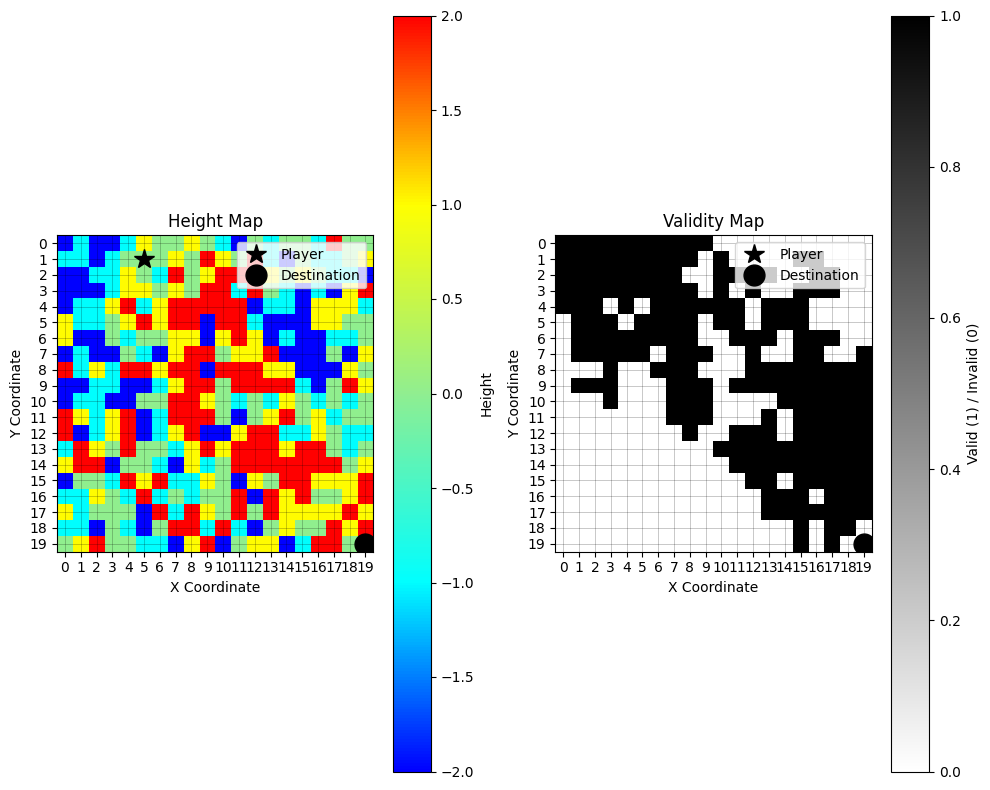

FUNC: Map visualization displayed with height and validity maps.
AI: I have visualized the map for you. Now, visualize yourself standing at the start of this thrilling mission! The varying colours represent the height levels. Remember, moving smoothly will need you to follow the gradient carefully, as you can only move between adjacent height levels.
    
    Begin your adventure by plotting your movements wisely through the rugged terrain. 
    
    Will you brave your path towards the North, sneak into the South, take the high route to the East or tread lightly to the West? Let me know your next move.
AI: I have visualized the map for you. Now, visualize yourself standing at the start of this thrilling mission! The varying colours represent the height levels. Remember, moving smoothly will need you to follow the gradient carefully, as you can only move between adjacent height levels.

Begin your adventure by plotting your movements wisely through the rugged terrain. 

Will you brave 

In [17]:
# gm_ai.add_message(ChatMessage(role=ChatRole.USER, text="Let's start the adventure!"))
await chat_in_terminal_async(gm_ai, stopword="!stop", verbose=True, ai_first=True)
gm_ai.save(f"gm-{int(time.time())}.json")